In [11]:
import os, random
os.environ['KERAS_BACKEND'] = "tensorflow"
import keras
from keras.datasets import mnist

import numpy as np
import tqdm
import IPython
from matplotlib import pyplot as plt

%matplotlib inline

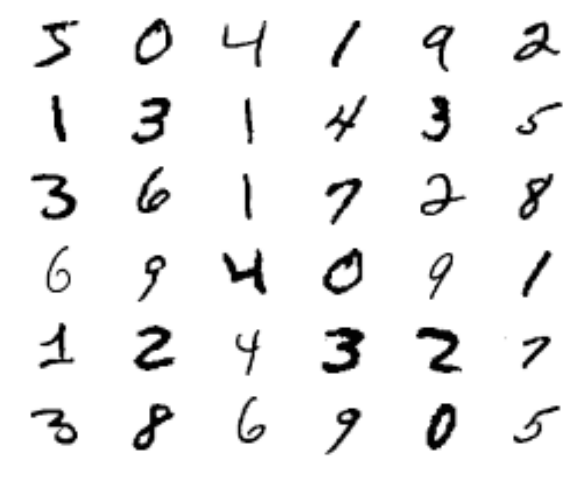

In [18]:
img_rows, img_cols = 28, 28
(X_train, y_train), (X_test, y_test) = mnist.load_data()

X_train = X_train.reshape(X_train.shape[0], 1, img_rows, img_cols)
X_test = X_test.reshape(X_test.shape[0], 1, img_rows, img_cols)

X_train = X_train.astype('float32')
X_test = X_test.astype('float32')

X_train /= 255
X_test /= 255

dim = (6,6)
plt.figure(figsize=(10,8))
for i in range(36):
    plt.subplot(dim[0],dim[1],i+1)
    img = X_train[i,0]
    plt.imshow(img, cmap="Greys")
    plt.axis("off")

In [106]:
shp = X_train.shape[1:]
dropout_rate = 0.25
opt = keras.optimizers.Adam(lr=1e-3)
dopt = keras.optimizers.Adam(lr=1e-4)

# generative model
nch = 200
g_input = keras.layers.Input(shape=[100])
H = keras.layers.core.Dense(nch*14*14, init='glorot_normal')(g_input)
H = keras.layers.normalization.BatchNormalization(mode=2)(H)
H = keras.layers.core.Activation('relu')(H)
H = keras.layers.core.Reshape( [nch, 14, 14] )(H)
H = keras.layers.convolutional.UpSampling2D(size=(2,2), dim_ordering="th")(H)

H = keras.layers.convolutional.Convolution2D(nch/2, 3, 3, border_mode='same', 
                                             init='glorot_uniform', dim_ordering="th")(H)
H = keras.layers.normalization.BatchNormalization(mode=2)(H)
H = keras.layers.core.Activation('relu')(H)
H = keras.layers.convolutional.Convolution2D(nch/4, 3, 3, border_mode='same', 
                                             init='glorot_uniform', dim_ordering="th")(H)
H = keras.layers.normalization.BatchNormalization(mode=2)(H)
H = keras.layers.core.Activation('relu')(H)
H = keras.layers.convolutional.Convolution2D(1, 1, 1, border_mode='same', 
                                             init='glorot_uniform', dim_ordering="th")(H)
g_V = keras.layers.core.Activation('sigmoid')(H)

generator = keras.models.Model(g_input, g_V)
generator.compile(loss='binary_crossentropy', optimizer=opt)
generator.summary()

# Build Discriminative model ...
d_input = keras.layers.Input(shape=shp)
H = keras.layers.convolutional.Convolution2D(256, 5, 5, subsample=(2, 2), 
                                             border_mode = 'same', activation='relu',
                                             dim_ordering="th")(d_input)
H = keras.layers.advanced_activations.LeakyReLU(0.2)(H)
H = keras.layers.core.Dropout(dropout_rate)(H)
H = keras.layers.convolutional.Convolution2D(512, 5, 5, subsample=(2, 2), 
                                             border_mode = 'same', activation='relu',
                                             dim_ordering="th")(H)
H = keras.layers.advanced_activations.LeakyReLU(0.2)(H)
H = keras.layers.core.Dropout(dropout_rate)(H)
H = keras.layers.core.Flatten()(H)
H = keras.layers.Dense(256)(H)
H = keras.layers.advanced_activations.LeakyReLU(0.2)(H)
H = keras.layers.core.Dropout(dropout_rate)(H)
d_V = keras.layers.Dense(2,activation='softmax')(H)
discriminator = keras.models.Model(d_input,d_V)
discriminator.compile(loss='categorical_crossentropy', optimizer=dopt)
discriminator.summary()

make_trainable(discriminator, False)
# Build stacked GAN model
gan_input = keras.layers.Input(shape=[100])
H = generator(gan_input)
gan_V = discriminator(H)
GAN = keras.models.Model(gan_input, gan_V)
GAN.compile(loss='categorical_crossentropy', optimizer=opt)
GAN.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
input_27 (InputLayer)            (None, 100)           0                                            
____________________________________________________________________________________________________
dense_28 (Dense)                 (None, 39200)         3959200     input_27[0][0]                   
____________________________________________________________________________________________________
batchnormalization_22 (BatchNorma(None, 39200)         78400       dense_28[0][0]                   
____________________________________________________________________________________________________
activation_29 (Activation)       (None, 39200)         0           batchnormalization_22[0][0]      
___________________________________________________________________________________________

In [88]:
# Freeze weights in the discriminator for stacked training
def make_trainable(net, val):
    net.trainable = val
    for l in net.layers:
        l.trainable = val

In [81]:
# generate some images
ntrain = 10000
trainidx = random.sample(range(0, X_train.shape[0]), ntrain)
XT = X_train[trainidx,:,:,:]

# Pre-train the discriminator network ...
noise_gen = np.random.uniform(0,1,size=[XT.shape[0],100])
generated_images = generator.predict(noise_gen)
X = np.concatenate((XT, generated_images))

n = XT.shape[0]
y = np.zeros([2*n,2])
y[:n,1] = 1
y[n:,0] = 1

real MNIST images


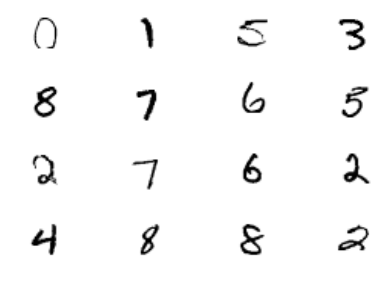

generatd images


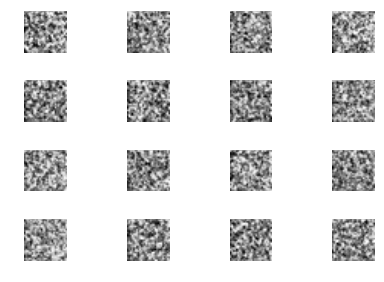

In [82]:
# plot real and generated images

print "real MNIST images"
plt.figure(1)
dim=(4,4)
for i in range(16):
    plt.subplot(dim[0],dim[1],i+1)
    img = XT[i,0,:,:]
    plt.imshow(img, cmap="Greys")
    plt.axis('off')
plt.tight_layout()
plt.show()

print "generatd images"
plt.figure(2)
for i in range(16):
    plt.subplot(dim[0],dim[1],i+1)
    img = generated_images[i,0,:,:]
    plt.imshow(img, cmap="Greys")
    plt.axis('off')
plt.tight_layout()
plt.show()


In [28]:
# pre-train descriminator
make_trainable(discriminator,True)
discriminator.fit(X,y, nb_epoch=1, batch_size=128)

Epoch 1/1
2000/2000 [==============================] - 45s - loss: 0.2039    


In [83]:
y_hat = discriminator.predict(X)
y_hat_idx = np.argmax(y_hat,axis=1)
y_idx = np.argmax(y,axis=1)
diff = y_idx-y_hat_idx
n_tot = y.shape[0]
n_rig = (diff==0).sum()
acc = n_rig*100.0/n_tot
print "Accuracy: %0.02f pct (%d of %d) right"%(acc, n_rig, n_tot)


Accuracy: 50.01 pct (10001 of 20000) right


In [103]:
def plot_loss(losses):
    IPython.display.clear_output(wait=True)
    IPython.display.display(plt.gcf())
    plt.figure(figsize=(10,8))
    plt.plot(losses["d"], label='discriminitive loss')
    plt.plot(losses["g"], label='generative loss')
    plt.legend()
    plt.show()

def plot_gen(n_epoch, n_ex=9,dim=(3,3), figsize=(8,8)):
    noise = np.random.uniform(0,1,size=[n_ex,100])
    generated_images = generator.predict(noise)

    plt.figure(figsize=figsize)
    for i in range(generated_images.shape[0]):
        plt.subplot(dim[0],dim[1],i+1)
        img = generated_images[i,0,:,:]        
        plt.imshow(img, cmap="Greys")
        plt.axis('off')
    plt.tight_layout()
    plt.savefig("imgs/all_digits_10k_imgs/{0}.png".format(n_epoch))
    plt.show()

In [ ]:
def train_for_n(nb_epoch=5000, plt_frq=25,BATCH_SIZE=32):
    for e in tqdm.tqdm(range(1001, nb_epoch)):
        # Make generative images
        image_batch = X_train[np.random.randint(0,X_train.shape[0],size=BATCH_SIZE),:,:,:]    
        noise_gen = np.random.uniform(0,1,size=[BATCH_SIZE,100])
        generated_images = generator.predict(noise_gen)
        
        # Train discriminator on generated images
        X = np.concatenate((image_batch, generated_images))
        y = np.zeros([2*BATCH_SIZE,2])
        y[0:BATCH_SIZE,1] = 1
        y[BATCH_SIZE:,0] = 1
        
        make_trainable(discriminator,True)
        d_loss  = discriminator.train_on_batch(X,y)
        losses["d"].append(d_loss)
    
        # train Generator-Discriminator stack on input noise to non-generated output class
        noise_tr = np.random.uniform(0,1,size=[BATCH_SIZE,100])
        y2 = np.zeros([BATCH_SIZE,2])
        y2[:,1] = 1
        
        make_trainable(discriminator,False)
        g_loss = GAN.train_on_batch(noise_tr, y2 )
        losses["g"].append(g_loss)
        
        # Updates plots
        plot_loss(losses)
        plot_gen(e+1)

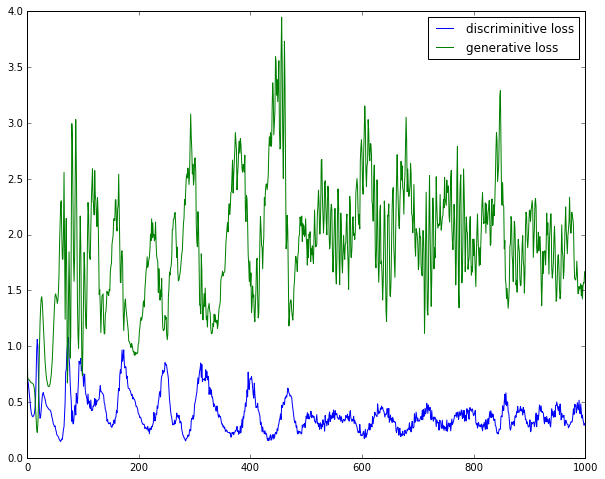

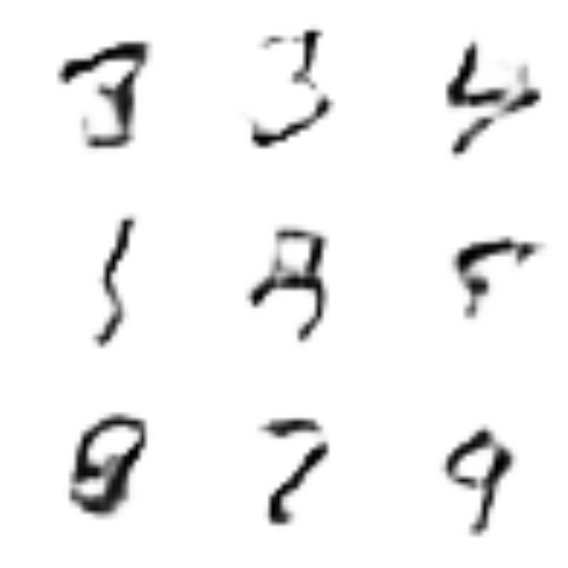

100%|██████████| 1000/1000 [5:50:22<00:00, 16.48s/it]


In [107]:
losses = {"d":[], "g":[]}
train_for_n(nb_epoch=1000, plt_frq=1, BATCH_SIZE=128)

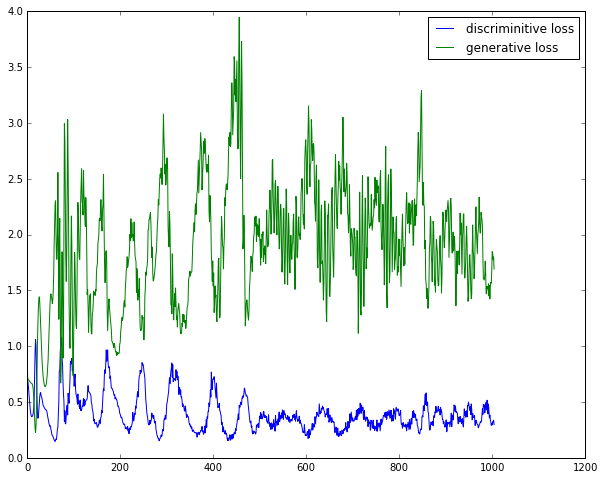

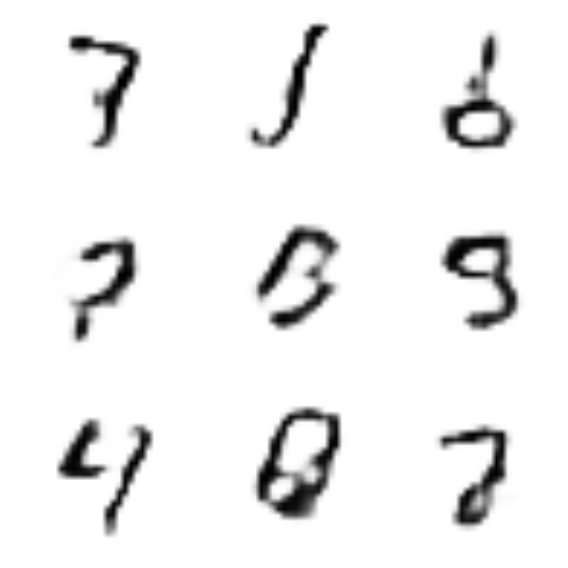

  0%|          | 5/8999 [01:23<41:18:02, 16.53s/it]

In [ ]:
train_for_n(nb_epoch=10000, plt_frq=1, BATCH_SIZE=128)

In [ ]:
plot_loss(losses)